<a href="https://colab.research.google.com/github/samruddhi972/RAW/blob/main/Object_Detection_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# --- Project Setup for Robocon 2026 Object Detection ---
# This script creates the necessary directories for organizing your data and model files.
# A good folder structure is crucial for keeping your project tidy and easy to manage.

def create_project_structure():
    """Creates the directory structure for the project."""
    print("Creating project directories...")

    # Root directory for the dataset
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
        print("Created: dataset/")

    # Directories for training and validation images and their labels
    for split in ['train', 'valid']:
        image_dir = os.path.join('dataset', split, 'images')
        label_dir = os.path.join('dataset', split, 'labels')

        if not os.path.exists(image_dir):
            os.makedirs(image_dir)
            print(f"Created: {image_dir.replace(os.sep, '/')}/")

        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
            print(f"Created: {label_dir.replace(os.sep, '/')}/")

    # Directory to save trained model weights
    if not os.path.exists('models'):
        os.makedirs('models')
        print("Created: models/")

    # Directory for output from inference
    if not os.path.exists('output'):
        os.makedirs('output')
        print("Created: output/")

    print("\nProject structure created successfully!")
    print("Next steps:")
    print("1. Place your training images in 'dataset/train/images/'.")
    print("2. Place your validation images in 'dataset/valid/images/'.")
    print("3. For each image, create a corresponding .txt file in the 'labels' folder.")
    print("   (e.g., for 'image1.jpg', create 'image1.txt' in 'dataset/train/labels/').")
    print("\nLabel format in the .txt file (one line per box):")
    print("<class_id> <x_center_norm> <y_center_norm> <width_norm> <height_norm>")
    print("Example for a 'real' box (class_id 0): 0 0.5 0.5 0.2 0.3")
    print("Example for a 'fake' box (class_id 1): 1 0.6 0.4 0.1 0.25")


if __name__ == '__main__':
    create_project_structure()

Creating project directories...
Created: dataset/
Created: dataset/train/images/
Created: dataset/train/labels/
Created: dataset/valid/images/
Created: dataset/valid/labels/
Created: models/
Created: output/

Project structure created successfully!
Next steps:
1. Place your training images in 'dataset/train/images/'.
2. Place your validation images in 'dataset/valid/images/'.
3. For each image, create a corresponding .txt file in the 'labels' folder.
   (e.g., for 'image1.jpg', create 'image1.txt' in 'dataset/train/labels/').

Label format in the .txt file (one line per box):
<class_id> <x_center_norm> <y_center_norm> <width_norm> <height_norm>
Example for a 'real' box (class_id 0): 0 0.5 0.5 0.2 0.3
Example for a 'fake' box (class_id 1): 1 0.6 0.4 0.1 0.25


Take input for dataset. (make sure its named 'dataset.zip').

In [2]:
# CODE CELL 1
from google.colab import files
import os

# Clean up any previous uploads
if os.path.exists('dataset.zip'):
    os.remove('dataset.zip')

print("Please select your dataset.zip file from your PC's file explorer.")
uploaded = files.upload()

for file_name in uploaded.keys():
  print(f'User uploaded file "{file_name}" with length {len(uploaded[file_name])} bytes')

Please select your dataset.zip file from your PC's file explorer.


Saving dataset.zip to dataset.zip
User uploaded file "dataset.zip" with length 1091147 bytes


In [3]:
# CODE CELL 2
import zipfile
import os

zip_path = 'dataset.zip'
extract_path = '/content/'

# Clean up previous extractions
if os.path.exists('/content/dataset'):
    import shutil
    shutil.rmtree('/content/dataset')

if os.path.exists(zip_path):
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset unzipped successfully.")
else:
    print(f"Error: The file '{zip_path}' was not found.")

Unzipping dataset...
Dataset unzipped successfully.


In [4]:
# CODE CELL 3
!ls -R /content/dataset


/content/dataset:
train  valid

/content/dataset/train:
images	labels

/content/dataset/train/images:
fake10.png  fake2.png  fake6.png  real10.png  real2.png  real6.png
fake11.png  fake3.png  fake7.png  real11.png  real3.png  real7.png
fake12.png  fake4.png  fake8.png  real12.png  real4.png  real8.png
fake1.png   fake5.png  fake9.png  real1.png   real5.png  real9.png

/content/dataset/train/labels:
fake10.txt  fake2.txt  fake6.txt  real10.txt  real2.txt  real6.txt
fake11.txt  fake3.txt  fake7.txt  real11.txt  real3.txt  real7.txt
fake12.txt  fake4.txt  fake8.txt  real12.txt  real4.txt  real8.txt
fake1.txt   fake5.txt  fake9.txt  real1.txt   real5.txt  real9.txt

/content/dataset/valid:
images	labels

/content/dataset/valid/images:
fake13.png  fake14.png	fake15.png  real13.png	real14.png  real15.png

/content/dataset/valid/labels:
fake13.txt  fake14.txt	fake15.txt  real13.txt	real14.txt  real15.txt


In [5]:
# CODE CELL 4
!pip install torch torchvision --quiet
!pip install pycocotools --quiet
print("Libraries installed.")


Libraries installed.


In [6]:
# CODE CELL 5
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class BoxDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        if not os.path.isdir(image_dir):
            raise FileNotFoundError(f"Image directory not found at {image_dir}")
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        label_name = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, x_center, y_center, width, height = [float(x) for x in line.strip().split()]
                    img_width, img_height = image.size

                    box_w, box_h = width * img_width, height * img_height
                    box_x, box_y = x_center * img_width, y_center * img_height

                    xmin = box_x - (box_w / 2)
                    ymin = box_y - (box_h / 2)
                    xmax = box_x + (box_w / 2)
                    ymax = box_y + (box_h / 2)

                    boxes.append([xmin, ymin, xmax, ymax])
                    # Add 1 to class_id: 0 ('real') -> 1, 1 ('fake') -> 2
                    # Class 0 is reserved for the background.
                    labels.append(int(class_id) + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        targets = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        if boxes.shape[0] > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            targets["area"] = area
            targets["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, targets

def collate_fn(batch):
    return tuple(zip(*batch))

print("BoxDataset class defined.")


BoxDataset class defined.


In [7]:
# CODE CELL 6
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

print("get_model function defined.")


get_model function defined.


pre-flight check.

In [8]:
# CODE CELL 7
from torch.utils.data import DataLoader
import os

# --- Paths ---
TRAIN_IMG_DIR = '/content/dataset/train/images'
TRAIN_LBL_DIR = '/content/dataset/train/labels'
VALID_IMG_DIR = '/content/dataset/valid/images'
VALID_LBL_DIR = '/content/dataset/valid/labels'

# --- Pre-flight Check ---
print("--- Running Pre-flight Check ---")
all_paths_ok = True
for name, path in {"Training Images": TRAIN_IMG_DIR, "Validation Images": VALID_IMG_DIR}.items():
    if not os.path.exists(path) or not os.listdir(path):
        print(f"❌ ERROR: {name} directory not found or is empty at: {path}")
        all_paths_ok = False
    else:
        print(f"✅ {name} directory found and contains files.")

if all_paths_ok:
    print("\n✅ Pre-flight check passed. Proceeding with training setup.")

    train_dataset = BoxDataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR, transform=T.ToTensor())
    valid_dataset = BoxDataset(VALID_IMG_DIR, VALID_LBL_DIR, transform=T.ToTensor())

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")

    # num_classes = 3 (background, real, fake)
    model = get_model(num_classes=3)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
else:
    print("\n🛑 ERROR: Pre-flight check failed. Please restart the session and run all cells from the top.")


--- Running Pre-flight Check ---
✅ Training Images directory found and contains files.
✅ Validation Images directory found and contains files.

✅ Pre-flight check passed. Proceeding with training setup.
Using device: cpu
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 158MB/s]


Training block.

In [9]:
# CODE CELL 8
import time

if 'train_loader' in locals():
    num_epochs = 15 # Increased epochs for better training on small datasets

    print("\n--- STARTING TRAINING ---")
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0

        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_train_loss += losses.item()

        avg_train_loss = total_train_loss / len(train_loader)
        lr_scheduler.step()

        # Validation Phase
        total_valid_loss = 0
        with torch.no_grad():
            for images, targets in valid_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_valid_loss += losses.item()
        avg_valid_loss = total_valid_loss / len(valid_loader)

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}")

    model_save_path = '/content/box_detector_final.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"\nTraining complete. Model saved to {model_save_path}")
else:
    print("🛑 Training skipped because the data loaders were not created. Please fix errors in the previous cell.")



--- STARTING TRAINING ---
Epoch 1/15 | Time: 472.83s | Train Loss: 0.2981 | Valid Loss: 0.1182
Epoch 2/15 | Time: 466.93s | Train Loss: 0.1247 | Valid Loss: 0.1124
Epoch 3/15 | Time: 454.92s | Train Loss: 0.1095 | Valid Loss: 0.0825
Epoch 4/15 | Time: 449.60s | Train Loss: 0.0862 | Valid Loss: 0.0735
Epoch 5/15 | Time: 454.00s | Train Loss: 0.0777 | Valid Loss: 0.0687
Epoch 6/15 | Time: 457.12s | Train Loss: 0.0708 | Valid Loss: 0.0692
Epoch 7/15 | Time: 454.50s | Train Loss: 0.0668 | Valid Loss: 0.0658
Epoch 8/15 | Time: 449.80s | Train Loss: 0.0659 | Valid Loss: 0.0663
Epoch 9/15 | Time: 452.33s | Train Loss: 0.0641 | Valid Loss: 0.0670
Epoch 10/15 | Time: 456.49s | Train Loss: 0.0669 | Valid Loss: 0.0659
Epoch 11/15 | Time: 455.09s | Train Loss: 0.0623 | Valid Loss: 0.0700
Epoch 12/15 | Time: 450.20s | Train Loss: 0.0643 | Valid Loss: 0.0661
Epoch 13/15 | Time: 452.71s | Train Loss: 0.0635 | Valid Loss: 0.0669
Epoch 14/15 | Time: 460.30s | Train Loss: 0.0628 | Valid Loss: 0.0656
Ep

This cell will take a random data(box) and predict.

Making a prediction on image: real14.png


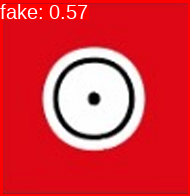

In [12]:
#CODE CELL 9
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import random
import os

# --- 1. DEFINE THE MODEL ARCHITECTURE ---
# The get_model function is included here to make this cell self-contained.
# This prevents the "NameError" if other cells haven't been run in the current session.
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --- 2. SETUP ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASS_NAMES = ['__background__', 'real', 'fake']

# --- 3. LOAD THE TRAINED MODEL ---
model = get_model(num_classes=3)
model_path = '/content/box_detector_final.pth'

# Check if the model file exists before loading
if not os.path.exists(model_path):
    print(f"ERROR: Model file not found at {model_path}")
    print("Please make sure you have run the training cell (Step 8) to create the model file.")
else:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Set the model to evaluation mode

    # --- 4. LOAD A RANDOM VALIDATION IMAGE ---
    VALID_IMG_DIR = '/content/dataset/valid/images'
    if not os.path.exists(VALID_IMG_DIR) or not os.listdir(VALID_IMG_DIR):
        print(f"ERROR: Validation images not found or directory is empty at {VALID_IMG_DIR}")
        print("Please ensure you have run the data upload and unzip cells (Steps 1 & 2).")
    else:
        image_files = os.listdir(VALID_IMG_DIR)
        random_image_name = random.choice(image_files)
        image_path = os.path.join(VALID_IMG_DIR, random_image_name)

        print(f"Making a prediction on image: {random_image_name}")
        image = Image.open(image_path).convert("RGB")

        # --- 5. PREPARE THE IMAGE AND GET PREDICTIONS ---
        transform = T.Compose([T.ToTensor()])
        img_tensor = transform(image).to(device)
        with torch.no_grad():
            prediction = model([img_tensor])

        # --- 6. DRAW THE PREDICTIONS ON THE IMAGE ---
        image_with_boxes = image.copy()
        draw = ImageDraw.Draw(image_with_boxes)
        try:
            font = ImageFont.truetype("LiberationSans-Regular.ttf", 20)
        except IOError:
            font = ImageFont.load_default()

        colors = {"real": "green", "fake": "red"}
        for i in range(len(prediction[0]['boxes'])):
            score = prediction[0]['scores'][i].item()
            label_index = prediction[0]['labels'][i].item()
            box = prediction[0]['boxes'][i].cpu().numpy()

            if score > 0.5: # Only show predictions with a high confidence score
                xmin, ymin, xmax, ymax = box
                label_name = CLASS_NAMES[label_index]
                color = colors.get(label_name, "blue")

                draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=3)
                text = f"{label_name}: {score:.2f}"
                text_bbox = draw.textbbox((xmin, ymin), text, font=font)
                draw.rectangle(text_bbox, fill=color)
                draw.text((xmin, ymin), text, fill="white", font=font)

        # Display the image in the Colab output
        display(image_with_boxes)



Inference on a New, Unseen Image:It will prompt you to upload an image.Choose any image of a box from your computer (ideally one that was not in your training or validation set) and upload it.

Please upload a new image to test the model.


Saving 1.png to 1.png

Making a prediction on image: 1.png


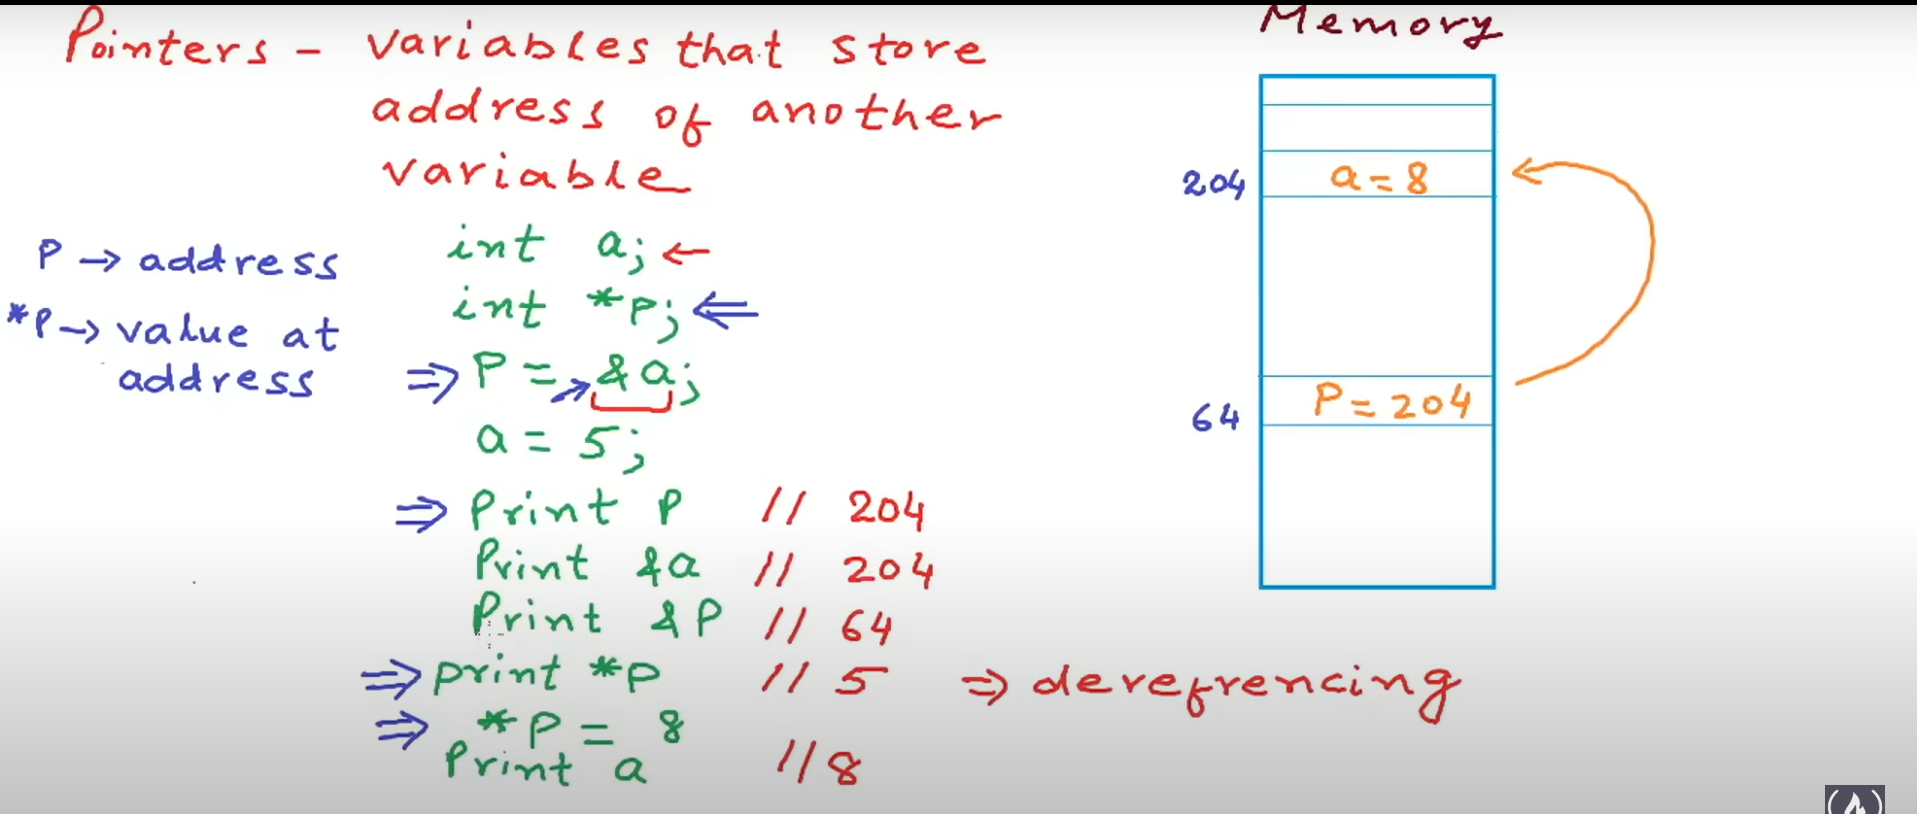

In [13]:
#CODE CELL 10
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import os
from google.colab import files
import io

# --- 1. DEFINE THE MODEL ARCHITECTURE ---
# This is included to make the cell self-contained
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --- 2. SETUP ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASS_NAMES = ['__background__', 'real', 'fake']

# --- 3. LOAD THE TRAINED MODEL ---
model = get_model(num_classes=3)
model_path = '/content/box_detector_final.pth'

if not os.path.exists(model_path):
    print(f"ERROR: Model file not found at {model_path}. Please run the training cell (Step 8) first.")
else:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # --- 4. UPLOAD A NEW IMAGE ---
    print("Please upload a new image to test the model.")
    uploaded = files.upload()

    if len(uploaded.keys()) == 0:
        print("No file uploaded. Please run the cell again.")
    else:
        # Get the first uploaded file
        image_name = next(iter(uploaded))
        image_data = uploaded[image_name]

        print(f"\nMaking a prediction on image: {image_name}")
        image = Image.open(io.BytesIO(image_data)).convert("RGB")

        # --- 5. PREPARE THE IMAGE AND GET PREDICTIONS ---
        transform = T.Compose([T.ToTensor()])
        img_tensor = transform(image).to(device)
        with torch.no_grad():
            prediction = model([img_tensor])

        # --- 6. DRAW THE PREDICTIONS ON THE IMAGE ---
        image_with_boxes = image.copy()
        draw = ImageDraw.Draw(image_with_boxes)
        try:
            font = ImageFont.truetype("LiberationSans-Regular.ttf", 20)
        except IOError:
            font = ImageFont.load_default()

        colors = {"real": "green", "fake": "red"}
        for i in range(len(prediction[0]['boxes'])):
            score = prediction[0]['scores'][i].item()
            if score > 0.5: # Confidence threshold
                box = prediction[0]['boxes'][i].cpu().numpy()
                label_index = prediction[0]['labels'][i].item()
                label_name = CLASS_NAMES[label_index]
                color = colors.get(label_name, "blue")

                xmin, ymin, xmax, ymax = box
                draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=3)
                text = f"{label_name}: {score:.2f}"
                text_bbox = draw.textbbox((xmin, ymin), text, font=font)
                draw.rectangle(text_bbox, fill=color)
                draw.text((xmin, ymin), text, fill="white", font=font)

        # Display the final image
        display(image_with_boxes)
